In [1]:
from IPython.display import HTML
HTML('''
    <style> body {font-family: "Roboto Condensed Light", "Roboto Condensed";} h2 {padding: 10px 12px; background-color: #E64626; position: static; color: #ffffff; font-size: 40px;} .text_cell_render p { font-size: 15px; } .text_cell_render h1 { font-size: 30px; } h1 {padding: 10px 12px; background-color: #E64626; color: #ffffff; font-size: 40px;} .text_cell_render h3 { padding: 10px 12px; background-color: #0148A4; position: static; color: #ffffff; font-size: 20px;} h4:before{ 
    content: "@"; font-family:"Wingdings"; font-style:regular; margin-right: 4px;} .text_cell_render h4 {padding: 8px; font-family: "Roboto Condensed Light"; position: static; font-style: italic; background-color: #FFB800; color: #ffffff; font-size: 18px; text-align: center; border-radius: 5px;}input[type=submit] {background-color: #E64626; border: solid; border-color: #734036; color: white; padding: 8px 16px; text-decoration: none; margin: 4px 2px; cursor: pointer; border-radius: 20px;}</style>
    <script> code_show=true; function code_toggle() {if (code_show){$('div.input').hide();} else {$('div.input').show();} code_show = !code_show} $( document ).ready(code_toggle);</script>
    <form action="javascript:code_toggle()"><input type="submit" value="Hide/show all code."></form>
''')

# Pre-process datasets

import packages

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

from sqlalchemy import inspect

srid = 4326
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

### Neighbourhoods

In [2]:
def comma_int_convert(string):
    string = str(string)
    if "," in string:
        string = string.replace(",", "")
    return string

Neighbourhoods = pd.read_csv("Neighbourhoods.csv")
Neighbourhoods["young"] = Neighbourhoods["0-4"] + Neighbourhoods["5-9"] + Neighbourhoods["10-14"] + Neighbourhoods["15-19"]
Neighbourhoods = Neighbourhoods.drop(columns = {"Unnamed: 0", "0-4","5-9", "10-14", "15-19"})
Neighbourhoods = Neighbourhoods.dropna()
Neighbourhoods = Neighbourhoods.drop_duplicates()

neighbour_area = Neighbourhoods["area_id"].tolist()
neighbour_area = list(map(str, neighbour_area)) # get a list of area_id, filter sa_2 after

## convert comma int to int
for col in Neighbourhoods.columns:
    Neighbourhoods[col] = Neighbourhoods[col].apply(comma_int_convert)

Neighbourhoods.head(3)

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,1098


### BusinessStats

In [3]:
BusinessStats = pd.read_csv("BusinessStats.csv")
BusinessStats = BusinessStats.dropna()
BusinessStats = BusinessStats.drop_duplicates()

BusinessStats["area_id"] = BusinessStats["area_id"].apply(lambda x: str(x))
BusinessStats = BusinessStats[BusinessStats["area_id"].isin(neighbour_area)] # only cotain regions in neighbourhoods

BusinessStats.head(3)

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
22,101051540,Goulburn Region,1891,38,52,1041,33,3,81
27,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19
28,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28


### Walking Count Sites

In [4]:
site = gpd.read_file("Walking_count_sites.geojson")
site = site.drop_duplicates()
site.columns= site.columns.str.lower() # lowercase all column names
site = site[["site_id", "geometry"]]

siteog = site.copy()  # creating a copy of the original for later
site['geom'] = site['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
site = site.drop(columns="geometry")  # deleting the old copy

site.head(3)


,site_id,geom
0,2,POINT (151.20286600009 -33.9073219995779)
1,3,POINT (151.177947185903 -33.8993387264436)
2,4,POINT (151.2166614819 -33.874375432462)


### Walking Count Records

In [5]:
record = pd.read_csv("Walking_count_surveys.csv")
record.columns= record.columns.str.lower() # lowercase all column names
record = record.rename(columns = {"siteid": "site_id"})
record = record[record["year"] == 2021]
record = record[["site_id", "totalcount"]] # select columns
# record = record.groupby(["site_id"]).mean()
record = record.drop_duplicates()
recordog = record.copy()
record.head(3)

,site_id,totalcount
2766,2,2346
2767,2,3204
2768,3,12126


### Parking meters

In [6]:
Parking_meters = gpd.read_file("Parking_meters.geojson")
Parking_meters = Parking_meters.dropna()
Parking_meters = Parking_meters.drop_duplicates()
Parking_meters = Parking_meters[['ApproxPaySpaces', 'geometry']] # select columns
Parking_meters = Parking_meters.rename(columns = {"ApproxPaySpaces" : "parkingspaces"})

Parking_metersog = Parking_meters.copy()  # creating a copy of the original for later
Parking_meters['geom'] = Parking_meters['geometry'].apply(lambda x: WKTElement(x.wkt, srid=srid))
Parking_meters = Parking_meters.drop(columns="geometry")  # deleting the old copy
Parking_meters.head(3)

,parkingspaces,geom
0,3,POINT (151.20674336712963 -33.86500973648068)
1,5,POINT (151.2028888685286 -33.892705794839934)
2,2,POINT (151.206094487671 -33.86711818106422)


### SA2_2016_AUST

In [7]:
sa2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

sydney_shape = sa2[sa2["SA3_NAME16"] == "Sydney Inner City"]
gsyd_shape = sa2[sa2["SA2_MAIN16"].isin(neighbour_area)] # only cotain regions in neighbourhoods
gsyd_shape.columns= gsyd_shape.columns.str.lower() # lowercase all column names
gsyd_shape = gsyd_shape.drop_duplicates()
gsyd_shape = gsyd_shape.dropna()

gsyd_shapeog = gsyd_shape.copy()  # creating a copy of the original for later
gsyd_shape['geom'] = gsyd_shape['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
gsyd_shape = gsyd_shape.drop(columns="geometry")  # deleting the old copy

gsyd_shape.head(3)

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code16,sa3_name16,sa4_code16,sa4_name16,gcc_code16,gcc_name16,ste_code16,ste_name16,areasqkm16,geom
22,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9035.1221,MULTIPOLYGON (((149.09631183700003 -34.4189438...
27,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6.4376,MULTIPOLYGON (((151.4137275700001 -33.46559324...
28,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32.0860,MULTIPOLYGON (((151.3539836770001 -33.49854010...


### break_and_enter

In [8]:
break_and_enter = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")
break_and_enter = break_and_enter.drop_duplicates()
break_and_enter = break_and_enter.dropna()
break_and_enter.columns= break_and_enter.columns.str.lower() # lowercase all column names
break_and_enter = break_and_enter.drop(columns={'contour', 'orig_fid'}) # drop irrelative cols

break_and_enterog = break_and_enter.copy()  # creating a copy of the original for later
break_and_enter['geom'] = break_and_enter['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
break_and_enter = break_and_enter.drop(columns="geometry")  # deleting the old copy

break_and_enter.head(3)

,objectid,density,shape_leng,shape_area,geom
0,1,Low Density,0.012138,0.000006,MULTIPOLYGON (((149.91078014700008 -37.0663631...
1,2,Low Density,0.019106,0.000015,MULTIPOLYGON (((149.9060088220001 -37.05836717...
2,3,Low Density,0.006068,0.000002,MULTIPOLYGON (((148.94249939000008 -37.0420853...


### school_catchments

future, school_catchments

In [9]:
catchments_future = gpd.read_file("school_catchments/catchments_future.shp")

catchments_futureog = catchments_future.copy()  # creating a copy of the original for later
catchments_future['geom'] = catchments_future['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchments_future = catchments_future.drop(columns="geometry")  # deleting the old copy

catchments_future.head(3)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,geom
0,2133,PRIMARY,Harbord PS,20200720,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,MULTIPOLYGON (((151.29768576390327 -33.7683218...
1,4450,PRIMARY,Berinba PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,MULTIPOLYGON (((149.10301282737197 -34.8212654...
2,4683,PRIMARY,Murrumbateman PS,20220110,2023,2023,2023,2023,2023,2023,2023,0,0,0,0,0,0,MULTIPOLYGON (((149.10556911272894 -34.8952307...


primary, school_catchments

In [10]:
catchments_primary = gpd.read_file("school_catchments/catchments_primary.shp")

catchments_primaryog = catchments_primary.copy()  # creating a copy of the original for later
catchments_primary['geom'] = catchments_primary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchments_primary = catchments_primary.drop(columns="geometry")  # deleting the old copy
catchments_primary.head(3)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((150.93563850416004 -33.7161211...
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.14085043012102 -33.7446267...
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,MULTIPOLYGON (((151.1833640465581 -33.74748398...


secondary, school_catchments

In [11]:
catchments_secondary = gpd.read_file("school_catchments/catchments_secondary.shp")

catchments_secondaryog = catchments_secondary.copy()  # creating a copy of the original for later
catchments_secondary['geom'] = catchments_secondary['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))  # applying the function
catchments_secondary = catchments_secondary.drop(columns="geometry")  # deleting the old copy

catchments_secondary.head(3)

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geom
0,8503,HIGH_COED,Billabong HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.67182402032344 -35.3144375...
1,8266,HIGH_COED,James Fallon HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((147.08733806259178 -35.8627146...
2,8505,HIGH_COED,Murray HS,20200507,N,N,N,N,N,N,N,Y,Y,Y,Y,Y,Y,None,MULTIPOLYGON (((146.81447829547324 -35.7834062...


#### merge 3 dataFrames

In [12]:
catchments = [catchments_future, catchments_primary, catchments_secondary]
catchments = pd.concat(catchments)

catchments.columns= catchments.columns.str.lower() # lowercase all column names
catchments = catchments.drop_duplicates()
catchments = catchments.dropna()

catchments.head(3)

,use_id,catch_type,use_desc,add_date,kindergart,year1,year2,year3,year4,year5,year6,year7,year8,year9,year10,year11,year12,geom,priority
679,4668,PRIMARY,Smalls Rd PS,20201221,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((151.10587500146278 -33.7910250...,N
813,5141,PRIMARY,Kyeemagh PS,20211221,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((151.16177431879754 -33.9453184...,N
1175,1943,PRIMARY,Frederickton PS,20200405,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,MULTIPOLYGON (((152.9147772022225 -30.85308878...,N


# Connect to database

In [13]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

In [14]:
db, conn = pgconnect(credentials)

Connected successfully.


In [15]:
query(conn, "select PostGIS_Version()")

,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### import SA_2 data

In [16]:
conn.execute("""
drop table if exists business;
drop table if exists neighbourhoods;
drop table if exists sa_2;
create table sa_2 (
    sa2_main16 integer primary key,
    sa2_5dig16 integer,
    sa2_name16 varchar(100),
    sa3_code16 integer,
    sa3_name16 varchar(100),
    sa4_code16 integer,
    sa4_name16 varchar(100),
    gcc_code16 varchar(100),
    gcc_name16 varchar(100),
    ste_code16 integer,
    ste_name16 varchar(100),
    areasqkm16 float,
    geom GEOMETRY(MULTIPOLYGON,4326));
    
    """)

In [17]:
gsyd_shape.to_sql('sa_2', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
conn.execute("create index main_idx on sa_2 (sa2_main16)") # create index on pk

In [18]:
query(conn, "select * from sa_2")
print("sa_2 imported")

sa_2 imported


### import break_and_enter data

In [19]:
conn.execute("""
drop table if exists break_and_enter;
create table break_and_enter (
    objectid integer,
    density varchar(50),
    shape_leng float,
    shape_area float,
    geom GEOMETRY(MULTIPOLYGON,4326)
)
""")
break_and_enter.to_sql('break_and_enter', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

594

In [20]:
query(conn, "select * from break_and_enter")
print("break_and_enter imported")

break_and_enter imported


### import school_catchments data

In [21]:
conn.execute("""
drop table if exists catchments;
create table catchments (
    use_id integer,
    catch_type varchar(100),
    use_desc varchar(100),
    add_date integer,
    kindergart varchar(100),
    year1 varchar(100),
    year2 varchar(100),
    year3 varchar(100),
    year4 varchar(100),
    year5 varchar(100),
    year6 varchar(100),
    year7 varchar(100),
    year8 varchar(100),
    year9 varchar(100),
    year10 varchar(100),
    year11 varchar(100),
    year12 varchar(100),
    geom GEOMETRY(MULTIPOLYGON,4326),
    priority varchar(100)
)
""")
catchments.to_sql('catchments', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})

8

In [22]:
query(conn, "select * from catchments")
print("catchments imported")

catchments imported


### BusinessStats

In [23]:
conn.execute("""
drop table if exists business;
create table business (
    area_id integer,
    area_name varchar(100),
    number_of_businesses integer,
    accommodation_and_food_services integer,
    retail_trade integer,
    agriculture_forestry_and_fishing integer,
    health_care_and_social_assistance integer,
    public_administration_and_safety integer,
    transport_postal_and_warehousing integer,
    foreign key (area_id) references sa_2(sa2_main16)
)
""")
BusinessStats.to_sql("business", con=conn, if_exists = "append", index = False)

309

In [24]:

print("business imported")

business imported


### Neighbourhoods

In [25]:
Neighbourhoods.head(3)

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,young
0,102011028,Avoca Beach - Copacabana,643.8,7590,2325,738.0,46996.0,1906.0,2214
1,102011029,Box Head - MacMasters Beach,3208.6,10986,3847,907.0,42621.0,1682.0,2635
2,102011030,Calga - Kulnura,76795.1,4841,1575,1102.0,42105.0,1182.0,1098


In [26]:
conn.execute("""
drop table if exists neighbourhoods;
create table neighbourhoods (
    area_id integer,
    area_name varchar(100),
    land_area float,
    population integer,
    number_of_dwellings integer,
    number_of_businesses float,
    median_annual_household_income float,
    avg_monthly_rent float,
    young integer,
    foreign key (area_id) references sa_2(sa2_main16)
)
""")
Neighbourhoods.to_sql("neighbourhoods", con = conn, if_exists = "append", index = False)

309

In [27]:
query(conn, "select * from neighbourhoods")
print("neighbourhoods imported")

neighbourhoods imported


### Parking

In [28]:
Parking_meters.head(3)
conn.execute("""
drop table if exists parking;
create table parking (
    parkingspaces integer,
    geom GEOMETRY(POINT,4326)
)
""")
Parking_meters.to_sql("parking", con = conn, if_exists = "append", index = False, dtype={'geom': Geometry('POINT', srid)})

376

In [29]:
query(conn, "select * from parking")
print("parking imported")

parking imported


### Walking Count Site

In [30]:
conn.execute("""
drop table if exists walking_site;
create table walking_site (
site_id integer primary key,
geom GEOMETRY(POINT,4326)

)
""")
site.to_sql("walking_site", con = conn, if_exists = "append", index = False, dtype={'geom': Geometry('POINT', srid)})

120

In [31]:
query(conn, "select * from walking_site")
print("walking_site imported")

walking_site imported


### Walking Count Records

In [32]:
conn.execute("""
drop table if exists walking_record;
create table walking_record (
site_id integer,
totalcount integer
)
""")
record.to_sql("walking_record", con = conn, if_exists = "append", index = False)

465

In [33]:
query(conn, "select * from walking_record")
print("walking_record imported")

walking_record imported


## Neighbourhood Join

### Join tables, select columns needed

In [53]:
sql = """
SELECT DISTINCT
    A.area_id,
    A.accom,
    A.retail,
    A.health,
    B.school * 1000 / cast(n.young as float) as "school",
    B.crime / land_area as "crime",
    
    A.geom
    
FROM 
    (SELECT
        n.area_id,
        s.geom,
        b.accommodation_and_food_services * 1000 / cast(n.population as float) as accom,
        b.retail_trade * 1000 / cast(n.population as float) as retail,
        b.health_care_and_social_assistance * 1000 / cast(n.population as float) as health

    FROM neighbourhoods n  
        left join business b on n.area_id = b.area_id
        left join sa_2 s on n.area_id = s.sa2_main16
        left join break_and_enter e on ST_Intersects(s.geom, e.geom)) A 
JOIN
    (SELECT
        count(s.geom) as "school",
        sum(e.shape_area) as "crime",
        b.area_id

    FROM neighbourhoods n  
        left join business b on n.area_id = b.area_id
        left join sa_2 s on n.area_id = s.sa2_main16
        left join break_and_enter e on ST_Intersects(s.geom, e.geom)
    
    GROUP BY b.area_id) B 

ON A.area_id = B.area_id

JOIN neighbourhoods n ON A.area_id = n.area_id
"""
query(conn, sql)
df = pd.read_sql_query(sql, conn)
df.head(3)

,area_id,accom,retail,health,school,crime,geom
0,101051540,2.999211,4.104183,2.604578,0.970874,3.318093e-09,0106000020E610000001000000010300000002000000C0...
1,102011028,4.347826,4.611331,7.905138,0.451671,NaN,0106000020E6100000010000000103000000010000005E...
2,102011029,2.093574,4.096122,3.914072,1.518027,1.060341e-08,0106000020E61000000100000001030000000100000000...


### Calculate S-score for each neighbourhood

In [54]:
# calc mean, for z-score
d = {}


# score functions
def z(x, mean, std):
    return (x - mean) / std

def sigmoid(x):
    return round(1 / (1 + np.exp(-x)), 3)


# new df recording z-score for all values
df_z = df.copy()
df['crime'] = df['crime'].fillna(0)

for column in df.columns:
    if column in ["area_id", "geom"]:
        continue
    # calc mean and sd
    std = df[column].std()
    mean = df[column].mean()
    print(column)
    print("mean:", mean, "std:", std, "\n")
        
    # calculating Z
    df_z[column] = df[column].apply(lambda x: z(x, mean, std))

score_col = df_z["accom"] + df_z["retail"] + df_z["health"] + df_z["school"] - df_z["crime"]
df_z["S_score"] = score_col
df_z["S_score"] = df_z["S_score"].apply(lambda x : sigmoid(x))
df_z.head(3)

accom
mean: 3.831107478633231 std: 3.6765597388208464 

retail
mean: 5.99287739904095 std: 5.247980562071106 

health
mean: 6.166416001860467 std: 4.8116397949536 

school
mean: 1.86287778562005 std: 4.369357206792234 

crime
mean: 3.2568260927523716e-06 std: 6.840343298592073e-06 



,area_id,accom,retail,health,school,crime,geom,S_score
0,101051540,-0.226270,-0.359890,-0.740255,-0.204150,-0.475635,0106000020E610000001000000010300000002000000C0...,0.258
1,102011028,0.140544,-0.263253,0.361358,-0.322978,-0.476120,0106000020E6100000010000000103000000010000005E...,0.597
2,102011029,-0.472598,-0.361426,-0.468103,-0.078925,-0.474570,0106000020E61000000100000001030000000100000000...,0.288


# Visualisation

### Greater Sydney Liveability

<AxesSubplot:>

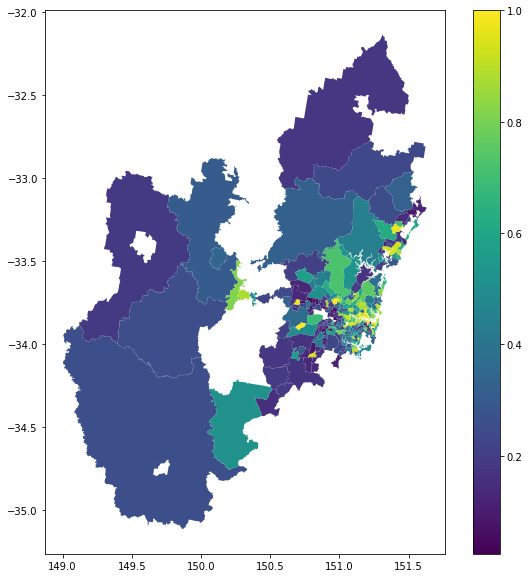

In [43]:
s_score = df_z["S_score"].tolist()
gsyd_shapeog["S_score"] = s_score
gsyd_shapeog.plot(column = "S_score", figsize=(10, 10), legend = True)

### avg_monthly_rent correlation

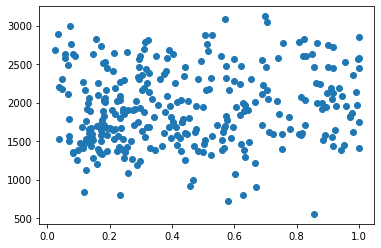

In [47]:
Neighbourhoods['median_annual_household_income'] = Neighbourhoods['median_annual_household_income'].apply(lambda x: float(x))
Neighbourhoods['avg_monthly_rent'] = Neighbourhoods['avg_monthly_rent'].apply(lambda x: float(x))

Neighbourhoods["S_score"] = s_score
plt.scatter(Neighbourhoods["S_score"], Neighbourhoods["avg_monthly_rent"])
plt.show()

### median_annual_household_income

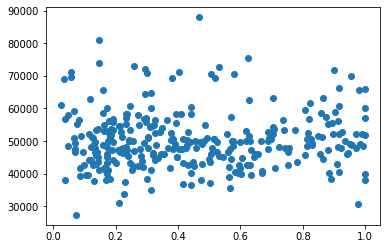

In [49]:
Neighbourhoods["S_score"] = s_score
plt.scatter(Neighbourhoods["S_score"], Neighbourhoods["median_annual_household_income"])
plt.show()

# Part 3 Join

### join tables, select columns needed

In [61]:
sql = """

SELECT 
    A.area_id,
    A.parking,
    A.flow,
    B.avg_monthly_rent,
    B.median_annual_household_income,
    B.accom  

FROM
    (SELECT
        n.area_id,
        sum(p.parkingspaces) as "parking",
        sum(A.sum) as "flow"

    FROM neighbourhoods n  
        left join business b on n.area_id = b.area_id
        left join sa_2 s on n.area_id = s.sa2_main16
        left join parking p on ST_Within(p.geom, s.geom)

        left join (select 
                       s.site_id,
                       sum(totalcount),
                       s.geom
                   from 
                       walking_site s
                       left join walking_record r on s.site_id = r.site_id
                   group by 
                       s.site_id) A 
             on ST_Within(A.geom, s.geom)

    WHERE s.sa3_name16 = 'Sydney Inner City'

    GROUP BY n.area_id) A
    
LEFT JOIN 
    (SELECT DISTINCT
        n.area_id,
        n.avg_monthly_rent,
        n.median_annual_household_income,
        b.accommodation_and_food_services * 1000 / cast(n.population as float) as accom  

    FROM neighbourhoods n  
        left join business b on n.area_id = b.area_id
        left join sa_2 s on n.area_id = s.sa2_main16
        left join break_and_enter e on ST_Intersects(s.geom, e.geom)

    WHERE s.sa3_name16 = 'Sydney Inner City') B ON A.area_id = B.area_id
"""

df2 = pd.read_sql_query(sql, conn)
df2 = df2.fillna(0)
df2


,area_id,parking,flow,avg_monthly_rent,median_annual_household_income,accom
0,117031329,10070.0,3.146186e+07,2491.0,59293.0,15.708072
1,117031330,0.0,3.592000e+04,2581.0,69680.0,7.799349
2,117031331,6941.0,1.266221e+07,2162.0,56691.0,5.603927
3,117031332,3745.0,1.738955e+07,2270.0,58210.0,7.322404
4,117031333,1925.0,7.288920e+06,2256.0,58253.0,8.400185
5,117031334,17432.0,3.308880e+07,2575.0,47393.0,9.591828
6,117031335,3130.0,1.251222e+07,2193.0,51347.0,5.599499
7,117031336,11592.0,5.446495e+07,2342.0,58396.0,15.223649
8,117031337,114180.0,1.211543e+09,2998.0,27311.0,54.337311
9,117031338,524.0,8.882160e+05,2302.0,57055.0,6.090327


### Calculate score S(z_parking + z_flow + z_income - z_rent- z_accomm)

In [59]:
df_z2 = df2.copy() 

# score functions
def z(x, mean, std):
    return (x - mean) / std

def sigmoid(x):
    return round(1 / (1 + np.exp(-x)), 3)

for column in df2.columns:
    if column == "area_id":
        continue
    # calc mean and sd
    std = df2[column].std()
    mean = df2[column].mean()
    print(column)
    print("mean:", mean, "std:", std, "\n")
        
    # calculating Z
    df_z2[column] = df2[column].apply(lambda x: z(x, mean, std))

score_col2 = df_z2["parking"] + df_z2["flow"] + df_z2["median_annual_household_income"] - df_z2["avg_monthly_rent"] - df_z2["accom"] 
df_z2["S_score"] = score_col2
df_z2["S_score"] = df_z2["S_score"].apply(lambda x : sigmoid(x))
df_z2

parking
mean: 16953.9 std: 34606.29156494203 

flow
mean: 138133561.4 std: 377528795.76889956 

avg_monthly_rent
mean: 2417.0 std: 253.08716109496964 

median_annual_household_income
mean: 54362.9 std: 11091.870370781577 

accom
mean: 13.567655070917297 std: 14.78399238619445 



,area_id,parking,flow,avg_monthly_rent,median_annual_household_income,accom,S_score
0,117031329,-0.198920,-0.282552,0.292389,0.444479,0.144779,0.384
1,117031330,-0.489908,-0.365794,0.647998,1.380930,-0.390172,0.566
2,117031331,-0.289338,-0.332349,-1.007558,0.209892,-0.538672,0.757
3,117031332,-0.381691,-0.319827,-0.580828,0.346840,-0.422433,0.657
4,117031333,-0.434282,-0.346582,-0.636144,0.350716,-0.349531,0.635
5,117031334,0.013815,-0.278243,0.624291,-0.628379,-0.268928,0.223
6,117031335,-0.399462,-0.332746,-0.885071,-0.271902,-0.538972,0.603
7,117031336,-0.154940,-0.221622,-0.296341,0.363609,0.112013,0.543
8,117031337,2.809492,2.843252,2.295652,-2.438894,2.757689,0.137
9,117031338,-0.474766,-0.363536,-0.454389,0.242709,-0.505772,0.590


/Users/little_sun/opt/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

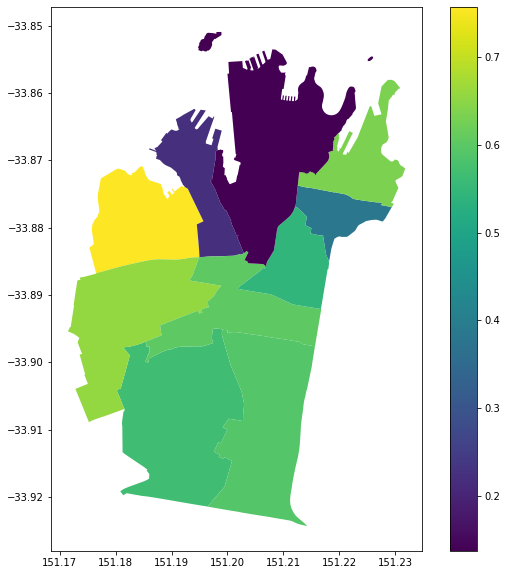

In [60]:

s_score = df_z2["S_score"].tolist()
sydney_shape["S_score"] = s_score
sydney_shape.plot(column = "S_score", figsize=(10, 10), legend = True)

In [34]:
inspect(db).get_table_names(schema='public')

['spatial_ref_sys',
 'break_and_enter',
 'catchments',
 'sa_2',
 'business',
 'neighbourhoods',
 'parking',
 'walking_site',
 'walking_record']

In [31]:
conn.close()
db.dispose()